In [1]:
# import dependencies

import sys
from dotenv import load_dotenv
import time

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2, l1, l1_l2


/tmp/ipykernel_1978254/498788028.py:12: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-18 01:28:24.303006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 01:28:24.797636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

2023-07-18 01:28:25.282710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-18 01:28:25.310083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-18 01:28:25.310372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
sys.path.append("../Datasets/")
from DataCreation import getDatasetV1, getDatasetV2, getDatasetV3

In [4]:
df = getDatasetV1(None)
df.drop(columns=['year', 'district'], inplace=True)
df.drop_duplicates(inplace=True)
df

,mean_total_snow,mean_temp,mean_total_rain,mean_total_precip,mean_snow_on_grnd,has_ergot
0,0.303979,0.451735,0.529384,1.189348,6.005903,False
1,0.116534,4.239744,0.328105,0.871078,0.860822,False
2,0.155237,1.628772,0.250507,0.790694,3.564932,True
3,0.135583,3.060292,0.332711,1.299196,1.054999,True
4,0.010502,2.796575,0.078265,0.908037,0.010959,True
...,...,...,...,...,...,...
1059,0.000000,0.777808,0.000000,1.151507,14.356164,True
1060,0.000000,2.653288,0.000000,1.097808,6.519178,True
1061,0.000000,1.931507,0.000000,2.099726,5.945205,True
1062,0.000000,1.386849,0.000000,1.102466,5.210959,True


In [5]:
df.columns

Index(['mean_total_snow', 'mean_temp', 'mean_total_rain', 'mean_total_precip',
       'mean_snow_on_grnd', 'has_ergot'],
      dtype='object')

In [6]:
# X = df.drop(columns=['incidence'])
# y = df['incidence'].astype(int)

X = df.drop(columns=['has_ergot'])
y = df['has_ergot'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversampling
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [7]:
model = Sequential()

layers_node = [32, 16, 32, 16, 8, 1]

for i in range(len(layers_node)):
    if i == 0:
        model.add(Dense(layers_node[i], activation='relu', kernel_regularizer=l1_l2(0.01) ,input_dim=X_train.shape[1])) #, kernel_regularizer=l2(0.01)
    elif(i == len(layers_node) - 1):
        model.add(Dense(layers_node[i], kernel_regularizer=l1_l2(0.01), activation='sigmoid')) # , kernel_regularizer=l2(0.01)
    # elif(i%2 == 0):
    #     model.add(Dropout(0.2))
    else:
        model.add(Dense(layers_node[i], activation='relu'))
        

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,937
Trainable params: 1,937
Non-trainabl

In [9]:
history = model.fit(X_resampled, y_resampled, epochs=500, batch_size=32, validation_split=0.2)

Epoch 1/500
 1/32 [..............................] - ETA: 19s - loss: 1.1022 - accuracy: 0.6562

2023-07-18 01:28:27.123622: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f13bc008f00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-18 01:28:27.123643: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-07-18 01:28:27.132392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-18 01:28:27.164462: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 1s 5ms/step - loss: 1.0824 - accuracy: 0.6214 - val_loss: 1.2311 - val_accuracy: 0.0000e+00
Epoch 2/500
32/32 [==============================] - 0s 2ms/step - loss: 1.0038 - accuracy: 0.6254 - val_loss: 1.2227 - val_accuracy: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 0s 2ms/step - loss: 0.9411 - accuracy: 0.6254 - val_loss: 1.1903 - val_accuracy: 0.0000e+00
Epoch 4/500
32/32 [==============================] - 0s 2ms/step - loss: 0.8869 - accuracy: 0.6254 - val_loss: 1.1282 - val_accuracy: 0.0000e+00
Epoch 5/500
32/32 [==============================] - 0s 2ms/step - loss: 0.8419 - accuracy: 0.6254 - val_loss: 1.1999 - val_accuracy: 0.0000e+00
Epoch 6/500
32/32 [==============================] - 0s 2ms/step - loss: 0.8084 - accuracy: 0.6254 - val_loss: 1.0847 - val_accuracy: 0.0000e+00
Epoch 7/500
32/32 [==============================] - 0s 2ms/step - loss: 0.7782 - accuracy: 0.6254 - val_loss: 1.0718 - val_accuracy: 0.0000e+

In [10]:
y_log = model.predict(X_test)
time.sleep(2)
y_pred = np.where(y_log > 0.5, 1, 0)

9/9 [==============================] - 0s 620us/step


In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score: ", auc_score)

print(classification_report(y_test, y_pred))

Accuracy:  0.7471264367816092
Precision:  0.8348623853211009
Recall:  0.8584905660377359
F1 Score:  0.8465116279069768
AUC Score:  0.5618983442433577
              precision    recall  f1-score   support

           0       0.30      0.27      0.28        49
           1       0.83      0.86      0.85       212

    accuracy                           0.75       261
   macro avg       0.57      0.56      0.56       261
weighted avg       0.73      0.75      0.74       261



### plot

In [12]:
import matplotlib.pyplot as plt

def evaluate_model(history):
    # Get the training and validation loss from the history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    # Check if the model is overfitting, underfitting, or performing well
    final_training_loss = np.array(training_loss).mean()
    final_validation_loss = np.array(validation_loss).mean()

    final_training_accuracy = np.array(training_accuracy).mean()
    final_validation_accuracy = np.array(validation_accuracy).mean()

    if final_training_loss < final_validation_loss:
        print("The model is likely underfitting.")
    elif final_training_loss > final_validation_loss:
        print("The model is likely overfitting.")
    else:
        print("The model is performing well and generalizing to new data.")

    if final_training_accuracy == 1.0 and final_validation_accuracy == 1.0:
        print("The model has achieved 100% accuracy on both training and validation data.")



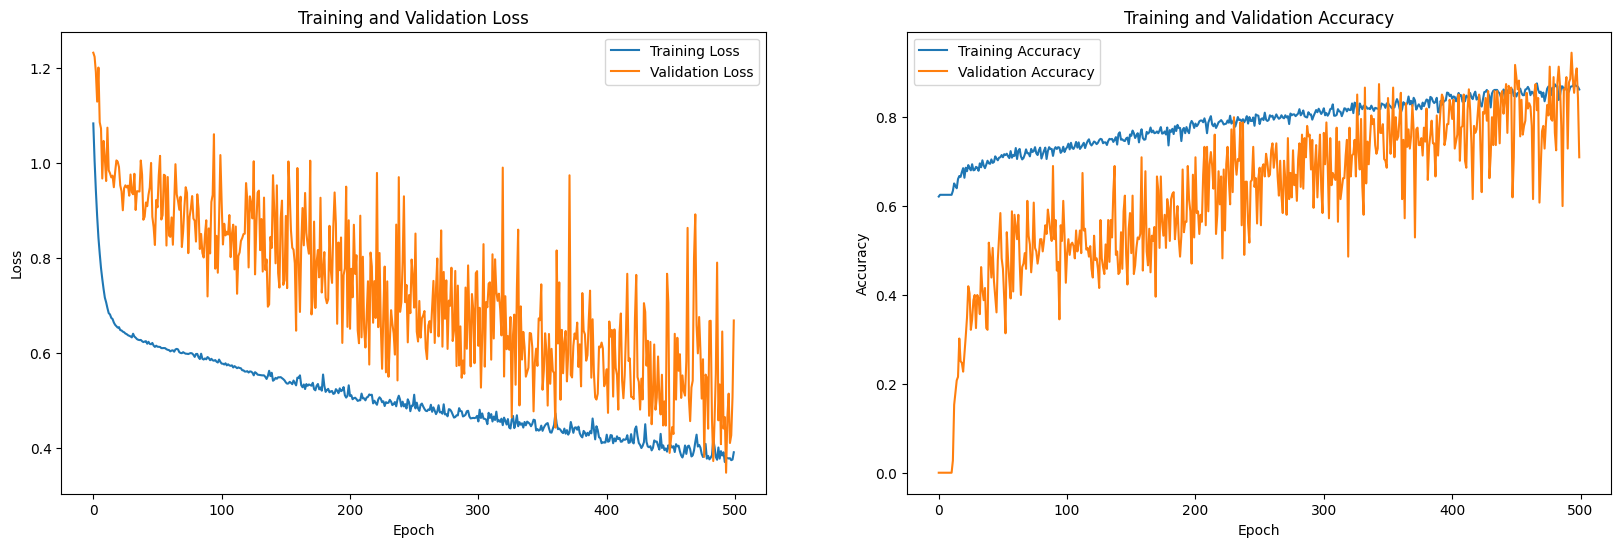

The model is likely underfitting.


In [13]:
evaluate_model(history)

### extra

In [ ]:
# prints weight with attribute
attributes = X_train.columns.tolist()
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

result = {}

for x, y in zip(attributes, weights):
    result[x] = y

result = pd.DataFrame(result)

result.transpose()
print(result.max())

---
# datset v1
---
---
### 500 epoches
- [48, 32, 24, 16, 8, 1]
    - Accuracy:  0.6917293233082706
    - Precision:  0.8009049773755657
    - Recall:  0.8232558139534883
    - F1 Score:  0.8119266055045871
    - AUC Score:  0.583076626877166
---

- [24, 24, 24, 24, 24, 1]
    - Accuracy:  0.6954887218045113
    - Precision:  0.8130841121495327
    - Recall:  0.8093023255813954
    - F1 Score:  0.8111888111888111  
    - AUC Score:  0.598815941470928
---
 
- [32, 16, 32, 16, 8, 1]
    - Accuracy:  0.7443609022556391
    - Precision:  0.8075313807531381
    - Recall:  0.8976744186046511
    - F1 Score:  0.8502202643171807
    - AUC Score:  0.5932807085098191
---

---
# datset v2
---
---
### 200 epoches
- [48, 32, 24, 16, 8, 1]
    - Accuracy:  0.7568199532346064
    - Precision:  0.845703125
    - Recall:  0.8490196078431372
    - F1 Score:  0.847358121330724
    - AUC Score:  0.6692982456140351
---

- [24, 24, 24, 24, 24, 1]
    - Accuracy:  0.77431906614786
    - Precision:  0.8287037037037037
    - Recall:  0.895
    - F1 Score:  0.8605769230769231 
    - AUC Score:  0.6216666666666668
---
 
- [32, 16, 32, 16, 8, 1]
    - Accuracy:  0.8054474708171206
    - Precision:  0.8472222222222222
    - Recall:  0.915
    - F1 Score:  0.8798076923076923
    - AUC Score:  0.6567543859649123
---

---
# datset v3
---
---
### 500 epoches
- [48, 32, 24, 16, 8, 1]
    - Accuracy:  0.754863813229572
    - Precision:  0.8549222797927462
    - Recall:  0.825
    - F1 Score:  0.8396946564885495
    - AUC Score:  0.5960299709237307
---

- [24, 24, 24, 24, 24, 1]
    - Accuracy:  0.7272018706157444
    - Precision:  0.8609913793103449
    - Recall:  0.7833333333333333
    - F1 Score:  0.8203285420944558
    - AUC Score:  0.6184261537314546
---
 
- [32, 16, 32, 16, 8, 1]
    - Accuracy:  0.6812159002338269
    - Precision:  0.8739290085679314
    - Recall:  0.7
    - F1 Score:  0.7773543821448012
    - AUC Score:  0.6299653321404608
---